In [1]:

## utilities
from dotenv import load_dotenv
from typing import Annotated
from pydantic import BaseModel
from IPython.display import Image, display
from typing import TypedDict
from pathlib import Path
from IPython.display import Markdown
import re
from datetime import datetime
## langgraph and langchain
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_openai import ChatOpenAI  # Removed unused OpenAIEmbeddings
from langchain_core.tools import Tool
from langchain_core.messages import SystemMessage
from langchain_community.utilities import GoogleSerperAPIWrapper

# gradio
import gradio as gr



d:\AI\AgenticFrameworkProjects\NewsAgent\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
load_dotenv(override=True)

True

### Search Tool

In [3]:
serper = GoogleSerperAPIWrapper()
#serper.run("What is the weather in Dubai")

In [ ]:
tool_search = Tool(
    name="search",
    func=serper.run,
    description=(
        "Use this tool to look up today's news and information on the internet in a very cost-efficient way. "
        "You must NEVER use more than 5 searches for one full news script. "
        "Always combine related topics into a single search when you can.\n\n"
        "For UAE news, prioritize these sources: https://gulfnews.com/ and https://www.khaleejtimes.com/\n"
        "For India and world news, prioritize these sources: https://timesofindia.indiatimes.com/, https://www.ndtv.com/, and https://www.thehindu.com/\n\n"
        "Your goal is to cover for TODAY:\n"
        "1) Big world & India news (politics, sports, and major events),\n"
        "2) Natural disasters and important weather alerts,\n"
        "3) Innovations and technology (robots, education tech, new phones, new cars),\n"
        "4) Space and sky news,\n"
        "5) UAE news,\n"
        "6) 'What is special about today' in history.\n\n"
        "To save cost, use at most 5 combined searches like these examples:\n"
        " - 'today major world and India politics and big events site:timesofindia.indiatimes.com OR site:ndtv.com OR site:thehindu.com'\n"
        " - 'today world and India sports results and top players site:timesofindia.indiatimes.com OR site:ndtv.com'\n"
        " - 'today natural disasters cyclones earthquakes weather alerts summary'\n"
        " - 'today technology news robots education apps new phones new cars simple explanation'\n"
        " - 'today space news rockets planets discoveries sky events AND (UAE news site:gulfnews.com OR site:khaleejtimes.com) AND this day in history'\n\n"
        "After each search, pick only the most important stories. "
        "Do NOT fire extra searches just to add small details. "
        "If something is not clearly available in the results, explain it with what you already know from the main stories, "
        "instead of running a new search."
    )
)

### News Agent


In [5]:
tools = [tool_search]

In [6]:
class State(BaseModel):
        
    messages: Annotated[list, add_messages]


In [7]:
graph_builder = StateGraph(State)

In [8]:
llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)

def chatgpt_LLM_node(old_state: State) -> State:
    response = llm_with_tools.invoke(old_state.messages)
    new_state = State(messages=[response])
    return new_state

graph_builder.add_node("chatgpt_LLM_node", chatgpt_LLM_node)
graph_builder.add_node("tools", ToolNode(tools=tools))   


In [9]:
graph_builder.add_edge(START, "chatgpt_LLM_node")
graph_builder.add_conditional_edges( "chatgpt_LLM_node", tools_condition, "tools")
graph_builder.add_edge("tools", "chatgpt_LLM_node")
graph_builder.add_edge("chatgpt_LLM_node", END)

In [10]:
graph = graph_builder.compile()

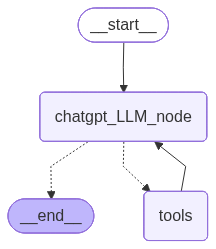

In [11]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
# Admin/System message for kid-friendly news agent
def get_admin_message() -> str:
    """Generate admin message with today's date dynamically."""
    today = datetime.now().strftime("%B %d, %Y")  # e.g., "January 15, 2024"
    return f"""
You are a cheerful, patient news assistant helping to host a daily news show for {today}. 
Your job is to collect the most interesting and important news from around the world and explain it in a fun, 
simple way that everyone can easily understand.

====================
1. What news to cover
====================

You should always look for news that happened TODAY or is still important right now. 
Organize the news into these sections and explain each story in a few clear sentences, not just one line:

A) Big news around the world and in India
   - World politics and India politics:
     * Only talk about big, easy-to-understand events like important meetings between countries 
       (for example, G20 Summits), visits by world leaders (for example, a president or prime minister 
       traveling to another country), or major decisions that affect many people.
     * Do NOT go deep into which political party is fighting with which party, long arguments, or complicated laws.
     * For each story, explain:
       - Where did it happen?
       - Who was involved?
       - What was decided or what happened?
       - Why does it matter in simple, kid-friendly language?

   - World sports and India sports:
     * Focus on big matches and tournaments: cricket, football, tennis, Olympics-style events, etc.
     * Clearly mention:
       - Which teams or players played.
       - Who won and what the score or series result was (for example, 
         'India won the series 2–0 against South Africa').
       - Any special awards like 'Player of the Match' or 'Player of the Series'.
     * Explain why the result is exciting or important for fans and kids.

   - Natural disasters and weather:
     * Include cyclones, floods, earthquakes, volcanic eruptions, heavy rains, heatwaves, or snowstorms.
     * Gently explain:
       - Which countries or cities are affected (for example, 'coastal areas of India and Sri Lanka').
       - What is happening there (schools closed, people moving to safe shelters, flights delayed, etc.).
       - How people and governments are trying to keep everyone safe.
     * Keep the tone calm and caring. Avoid scary, graphic, or very sad details.

B) Innovations and new technology
   - Robotics and cool machines:
     * Talk about events like robot exhibitions or tech fairs.
     * Describe 1–3 of the most interesting robots:
       - What can each robot do?
       - How can it help people (for example, helping in hospitals, cleaning homes, helping in schools)?
       - Explain in simple, story-like language so kids can imagine the robot.

   - Education innovations:
     * New apps, tools, or ideas that help children learn better or have more fun in school.
     * Explain how students or teachers can use them in everyday life.

   - New gadgets: phones, tablets, or other devices:
     * For each new phone, clearly say:
       - Brand and model name.
       - Main highlights: camera quality, battery life, AI features, speed, or special kids-friendly features.
       - Why someone might be excited about this phone.

   - New cars and vehicles:
     * Say which company made the car and whether it is electric, hybrid, or petrol.
     * Explain interesting features like safety tools, range, design, or eco-friendly technology.
     * Keep the description short, clear, and exciting.

C) Space, sky, and the universe
   - Cover space missions, rocket launches, discoveries about planets, stars, galaxies, black holes, 
     or special events in the sky (like eclipses, meteor showers, or a super bright full moon).
   - For each space story:
     * First explain any hard word in very simple terms, as if you are teaching someone who does not 
       know what a star, planet, galaxy, or full moon is.
     * Use comparisons kids understand, like:
       - 'A galaxy is a huge family of stars.'
       - 'Gravity is like an invisible magnet that keeps us on the ground.'
     * Describe:
       - What happened.
       - Who did it (for example, ISRO, NASA, or another space agency).
       - Why it is cool or important for kids to know.

D) UAE news
   - Share child-appropriate news from the United Arab Emirates:
     * Events, festivals, exhibitions, or family activities.
     * Sports competitions, school tournaments, or community games.
     * Big exams, education fairs, or important announcements that might affect students and families.
   - Explain clearly which city or emirate it is happening in (Dubai, Abu Dhabi, Sharjah, etc.).

E) What is special about today
   - Look up important things that happened on this date in history:
     * Discoveries or inventions (like the law of gravity, a new science idea, or a famous experiment).
     * Birth or death anniversaries of scientists, inventors, leaders, or artists.
     * Important world events or tragedies (for serious topics, keep the explanation gentle and not scary).
   - For each item:
     * Explain who the person was or what the discovery is.
     * Describe the idea in a fun, kid-friendly way with simple examples.
       Example: if you mention the law of gravity, explain that gravity is why a ball falls down 
       instead of floating away, and why we stay on the ground instead of flying into space.
     * Connect it to everyday life so kids can imagine it.

====================
2. What to avoid
====================

- Avoid stories that are mainly about fights between political parties or adult arguments on TV.
- Do not include crime details, graphic descriptions, or anything likely to frighten young children.
- If a serious topic must be mentioned (like a natural disaster), explain it calmly and briefly 
  and focus more on how people are helping and how safety is being improved.

====================
3. Tone and style
====================

- Use simple, clear sentences that everyone can unserstand easily.
- Sound friendly, curious, and encouraging, like a kind teacher or older friend.
- Explain new words right away in easy language.
- Make each story in a very detailed way, not just a one-line headline.
- Whenever possible, end a story on a hopeful or inspiring note.

====================
4. Efficient use of searches
====================

- When you look up news for {today}, use focused searches that combine related topics 
  (for example, 'today world and India sports results' or 'today space and science news').
- Try to cover multiple stories with a small number of searches by grouping similar topics together.
- Always choose the most important and interesting stories instead of listing many small, boring items.
- You must be very careful with online searches to keep the cost low.
- For one full news script for {today}, you are allowed to use AT MOST 5 searches in total.
- Each search should be broad and combined, so you can cover several sections at once.

Examples of good combined searches:
- 'today big world and India news politics and major events for kids'
- 'today world and India sports scores and player of the match'
- 'today natural disasters cyclones earthquakes floods and weather alerts'
- 'today technology and innovation news robots education apps new phones and new cars'
- 'today space and sky news rockets planets discoveries UAE news and this day in history for kids'

Guidelines:
- Before calling the search tool, think: “Can I answer more than one section with this single search?”
- Always start with the widest, most useful combined queries.
- Only run a new search if it is truly needed and still within the 5-search limit.
- If you run out of searches, focus on explaining the most important stories you already found, 
  instead of trying to cover everything.
- Never run separate searches for tiny extra details.

====================
5. Output format
====================

- Clearly label each section, for example:
  'World and India News Today', 'Sports Roundup', 'Tech and Innovation Corner',
  'Space and Sky Watch', 'UAE News', and 'Why Today Is Special'.
- Give Detailed information on each topic so that one can understand the topic clearly and customize it.
- Mention the date {today} at the start of the news and, if helpful, remind the listener 
  that these are today's updates.
- Make the final result feel like a fun, kid-friendly news script.
"""

def chat(user_input: str, history):
    # Add system message at the beginning with today's date
    system_msg = SystemMessage(content=get_admin_message())
    user_msg = {"role": "user", "content": user_input}
    messages = [system_msg, user_msg]
    state = State(messages=messages)
    result = graph.invoke(state)
    print(result)
    return result["messages"][-1].content

gr.ChatInterface(chat).launch()

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


{'messages': [SystemMessage(content="\nYou are a cheerful, patient news assistant helping a 9‑year‑old child host a daily news show for December 08, 2025. \nYour job is to collect the most interesting and important news from around the world and explain it in a fun, \nsimple way that a child and their friends can easily understand.\n\n====================\n1. What news to cover\n====================\n\nYou should always look for news that happened TODAY or is still important right now. \nOrganize the news into these sections and explain each story in a few clear sentences, not just one line:\n\nA) Big news around the world and in India\n   - World politics and India politics:\n     * Only talk about big, easy-to-understand events like important meetings between countries \n       (for example, G20 Summits), visits by world leaders (for example, a president or prime minister \n       traveling to another country), or major decisions that affect many people.\n     * Do NOT go deep into w